### EM算法(Expectation Maximization)

目录：
* 1.EM算法案例:k-means
* 2.基础知识（极大似然估计，琴生不等式）
* 3.EM算法证明
* 4.EM算法代码实现-高斯混合模型

#### 1.EM算法案例：K-Means

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
#没有分布构造的数量
num_pts = 100
#构造 三个高斯分布的数据
def get_data():
    np.random.seed(2)
    # Sample data points from three different Gaussians.
    u1, u2, u3 = np.asarray([1.0, 1.0]), np.asarray([-1.0, 1.0]), np.asarray([5.0, 5.0])
    sigma1, sigma2, sigma3 = np.random.rand(2, 2), np.random.rand(2, 2), np.random.rand(2, 2)
    sigma1 = np.dot(sigma1, sigma1.T) * 1.0
    sigma2 = np.dot(sigma2, sigma2.T) * 5.0
    sigma3 = np.dot(sigma3, sigma3.T) * 2.0

    
    samples1 = np.random.multivariate_normal(u1, sigma1 * np.ones((2, 2)), size=num_pts)
    samples2 = np.random.multivariate_normal(u2, sigma2 * np.ones((2, 2)), size=num_pts)
    samples3 = np.random.multivariate_normal(u3, sigma3 * np.ones((2, 2)), size=num_pts)
    
    return samples1,samples2,samples3

In [8]:
samples1,samples2,samples3 = get_data()

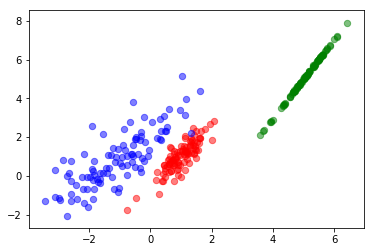

In [9]:
#绘制生成的数据点
def draw_data(samples1,samples2,samples3):
    # Plot for visualization.
    plt.figure()
    plt.scatter(samples1[:, 0], samples1[:, 1], s=40, c="r", alpha=0.5)
    plt.scatter(samples2[:, 0], samples2[:, 1], s=40, c="b", alpha=0.5)
    plt.scatter(samples3[:, 0], samples3[:, 1], s=40, c="g", alpha=0.5)
    
draw_data(samples1,samples2,samples3)

In [32]:
def my_k_means(datas,k=3,num_iters=10):
    #随机生成k个中心点
    centers = np.random.rand(k,2)
    losses = []
    # Save for repeated use.
    xdist = np.sum(datas * datas, axis=1)
    ids = []
    for _ in range(num_iters):
        #E 步
        # Compute distance to each center.
        cdist = np.sum(centers * centers, axis=1)
        consts = xdist[:, np.newaxis] + cdist
        dists = consts - 2 * np.dot(samples, centers.T)
        
        ids = np.argmin(dists,axis=1)
        losses.append(np.sum(np.min(dists, axis=1)))
        
        #M步
        for i in range(k):
            centers[i,:] = np.mean(datas[ids == i],axis=0)
    #绘制聚类后的数据        
    colors = ["r", "b", "g"]
    for i in range(k):
        plt.scatter(samples[ids == i, 0], samples[ids == i, 1], c=colors[i], s=40, alpha=0.5)
        
    #绘制loss
    plt.figure()
    plt.plot(np.arange(num_iters), losses, "bo-", linewidth=4, markersize=10)
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("K-means loss function")

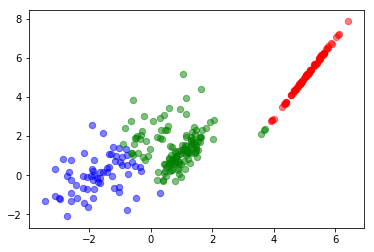

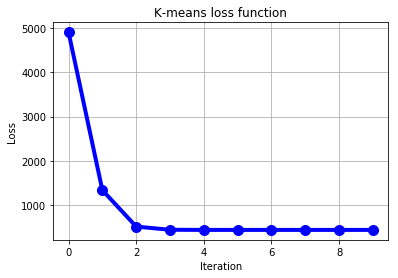

In [35]:
#合并数据
samples = np.vstack([samples1, samples2, samples3])
rorder = np.arange(num_pts * 3)
rorder = np.random.shuffle(rorder)
samples = samples[rorder, :].squeeze()
#调用k-means聚类
my_k_means(samples,k=3,num_iters=10)

#### 2.基础知识（极大似然估计，琴生不等式）

* 极大似然估计

 功能：根据“样本服从的分布模型”，“随机抽样的样本” 获取模型的参数
 
 背景：样本X={$x_1,x_2,x_3,,,,,,x_n$}, 概率密度函数$P(x_i| \theta)$ , 由于样本独立同分布，则样本的联合概率为：$L(\theta) = L(x_1,x_2,x_3,,,,x_n;\theta) = \prod P(x_i;\theta)$
 
 目标函数：argmax($L(\theta)$)
 
 步骤：
    * 由于连乘会受噪音影响，因此将上面目标函数转化成：$H(\theta) = ln(L(\theta)) =  \Sigma P(x_i;\theta)$
    * 对上面方程求导，领导数为0，得到似然方程。求解似然方程得到参数的解
  
  
* 琴生不等式
 
 功能：诠释函数的凹凸性
 
 理解：
     * 凹函数：$Ef(x) >= f(Ex)$ 
 
     * 凸函数：$Ef(x) <= f(Ex)$ 
 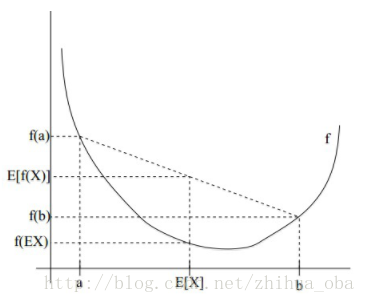
 
 


#### 3.EM算法证明

* 背景：样本：{$x_1,x_2,,,,,x_n$},每个样本对应的分类$z_i$未知。目标是估计$P(x_i;\theta)$的参数$\theta$ ,及找到合适的$\theta$和$Z_i$使得$L(\theta)$最大
* $log(L(\theta)) = \Sigma P(x_i;\theta)$

   $ = \Sigma  log \Sigma Q(z_i) {P(x_i,z_i;\theta) \over  Q(z_i)}$
    
   $ >= \Sigma \Sigma Q(z_i)  log {P(x_i,z_i;\theta) \over  Q(z_i)}$ 
   
* 条件：
   * $ \Sigma Q(z_i) = 1$
   * $ {P(x_i,z_i;\theta) \over  Q(z_i)} = c $ (若要等号相等 log内取常数)
   
* 有条件可得：
   * $ \Sigma P(x_i;\theta) = c$
   * $ Q(z_i) = {P(x_i;\theta) \over  \Sigma P(x_i,z_i;\theta)} = {P(x_i;\theta) \over  P(x_i;\theta)} = P(z_i|x_i;\theta) $
 
* 算法步骤
   * 初始化$\theta$,重复E步和M步
   * E步：根据初始化或者上一步求的的$\theta$值，利用公式$ Q(z_i) = P(z_i|x_i;\theta) $ 求取 $\theta$
   * M步：根据E步获取的$ Q(z_i) $ 使得 $ \Sigma \Sigma Q(z_i)  log {P(x_i,z_i;\theta) \over  Q(z_i)}$ 最大得到$\theta$值
   

#### 4.EM算法代码实现-高斯混合模型（GMM）